# Dataset preparation

Code for post-processed datasets

1. TAO merged / gridded
2. TAO interped to EUC space

## make TAO hi-res zarr dataset

Takes 10m & hourly data and combines them.

Merges in 10m, 25m current meters with the ADCP data where ADCP is not available at these depths

Filenames:
1. `tao_eq_hr_merged_cur.zarr` : merged adcp, cur but not on uniform grid
2. `tao_eq_hr_gridded.zarr` : merged adcp, cur, temp gridded on ADCP grid

In [1]:
%load_ext watermark

import dask
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import pump

dask.config.set({"array.slicing.split_large_chunks": True})
mpl.rcParams["figure.dpi"] = 140 

%watermark -iv

xarray     : 0.17.1.dev3+g48378c4b1
pump       : 0.1
distributed: 2021.2.0
numpy      : 1.20.1
dcpy       : 0.1
matplotlib : 3.3.4
dask       : 2021.2.0



In [207]:
import dcpy.interpolate

In [3]:
cluster = distributed.LocalCluster(n_workers=3, threads_per_worker=2)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35417 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 6 Memory: 33.39 GB


In [2]:
def plot_count(da):
    counts = (
        da.reindex(longitude=[-204, -195, -170, -140, -110])
        .groupby("time.year")
        .count()
    )

    fg = counts.plot(
        x="year",
        col="longitude",
        add_colorbar=True,
        vmin=0,
        vmax=8000,
        levels=5,
        xlim=(1985, 2021),
        cmap=mpl.cm.Reds,
        ylim=(-300, 0)
    )

    for ax in fg.axes.flat:
        ax.grid(True, which="both", axis="x")
        ax.set_xticks(np.arange(1990, 2022), minor=True)

## Gridded TAO data

In [251]:
adcp = pump.obs.read_tao_adcp(freq='hr').reindex(depth=np.arange(-300, 1, 5.0))
temp = pump.obs.read_eq_tao_temp_hr().isel(depth=slice(1, None))
salt = pump.obs.read_eq_tao_salt_hr().squeeze()

# tao = xr.merge([adcp, temp]).chunk({"time": -1, "longitude": 1, "depth": 10})

100%|██████████| 5/5 [00:00<00:00, 31.18it/s]


### 10min vs hourly T

In [3]:
temphr = pump.obs.tao_read_and_merge("hr", "temp").T

In [23]:
temp10m = pump.obs.tao_read_and_merge("10m", "temp").T

100%|██████████| 5/5 [00:00<00:00, 68.89it/s]
/home/deepak/work/python/xarray/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/deepak/work/python/xarray/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value

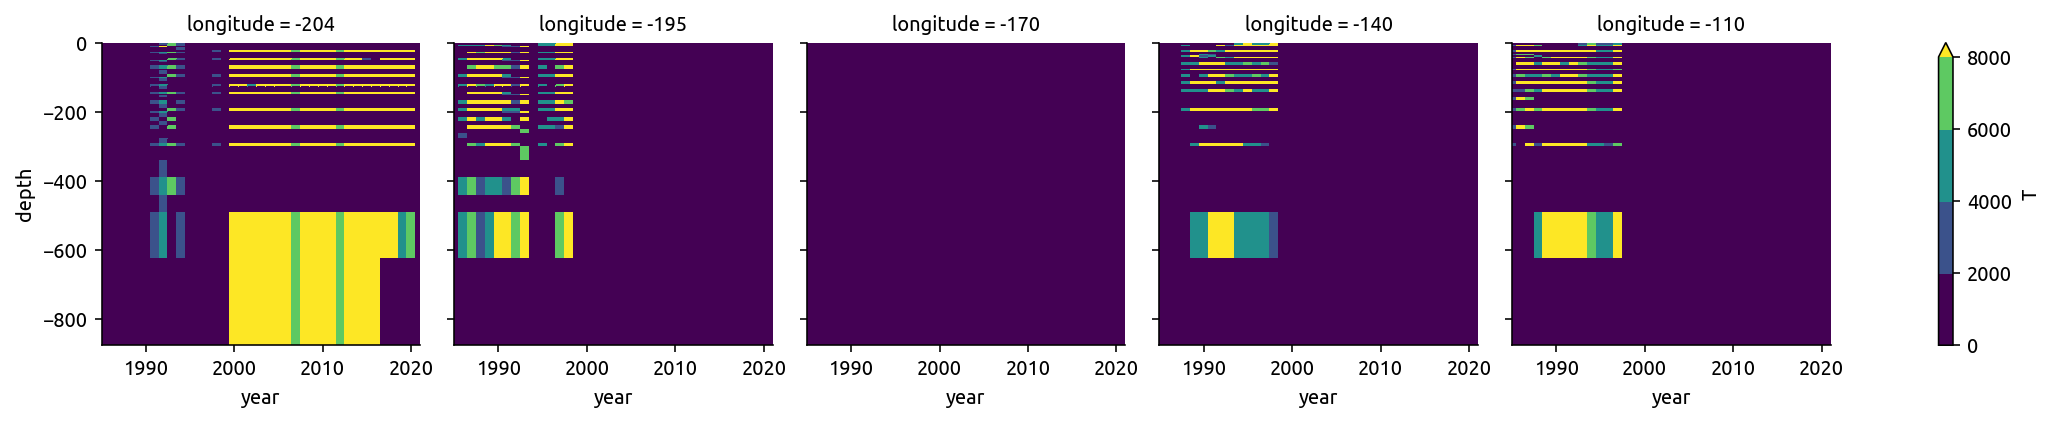

In [24]:
plot_count(temphr)

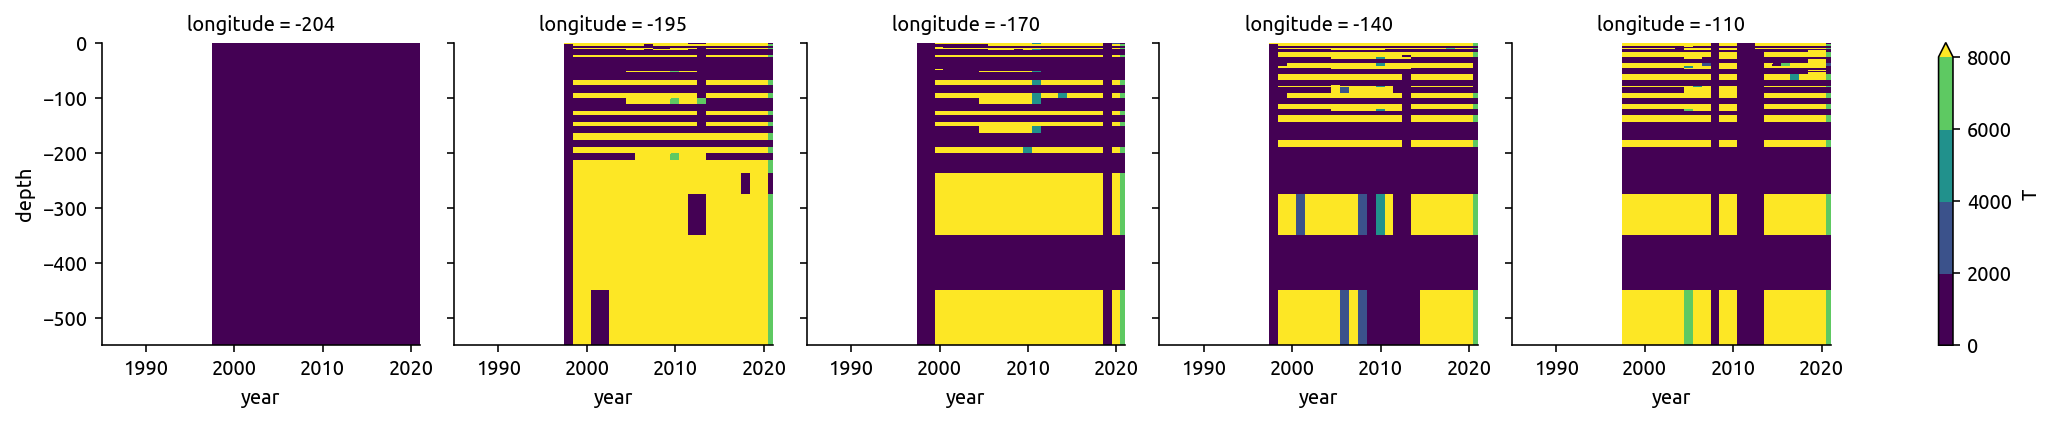

In [43]:
plot_count(temp10m)

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


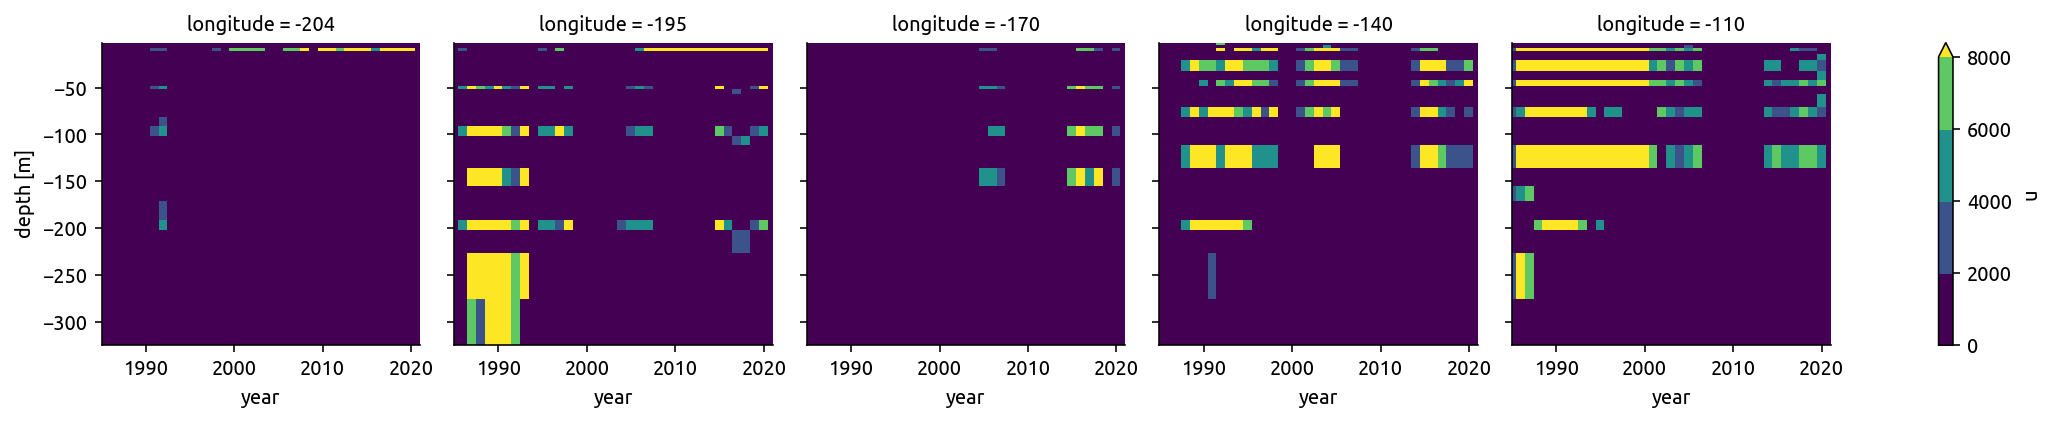

In [65]:
plot_count(hrcur.u)

### Check data availability

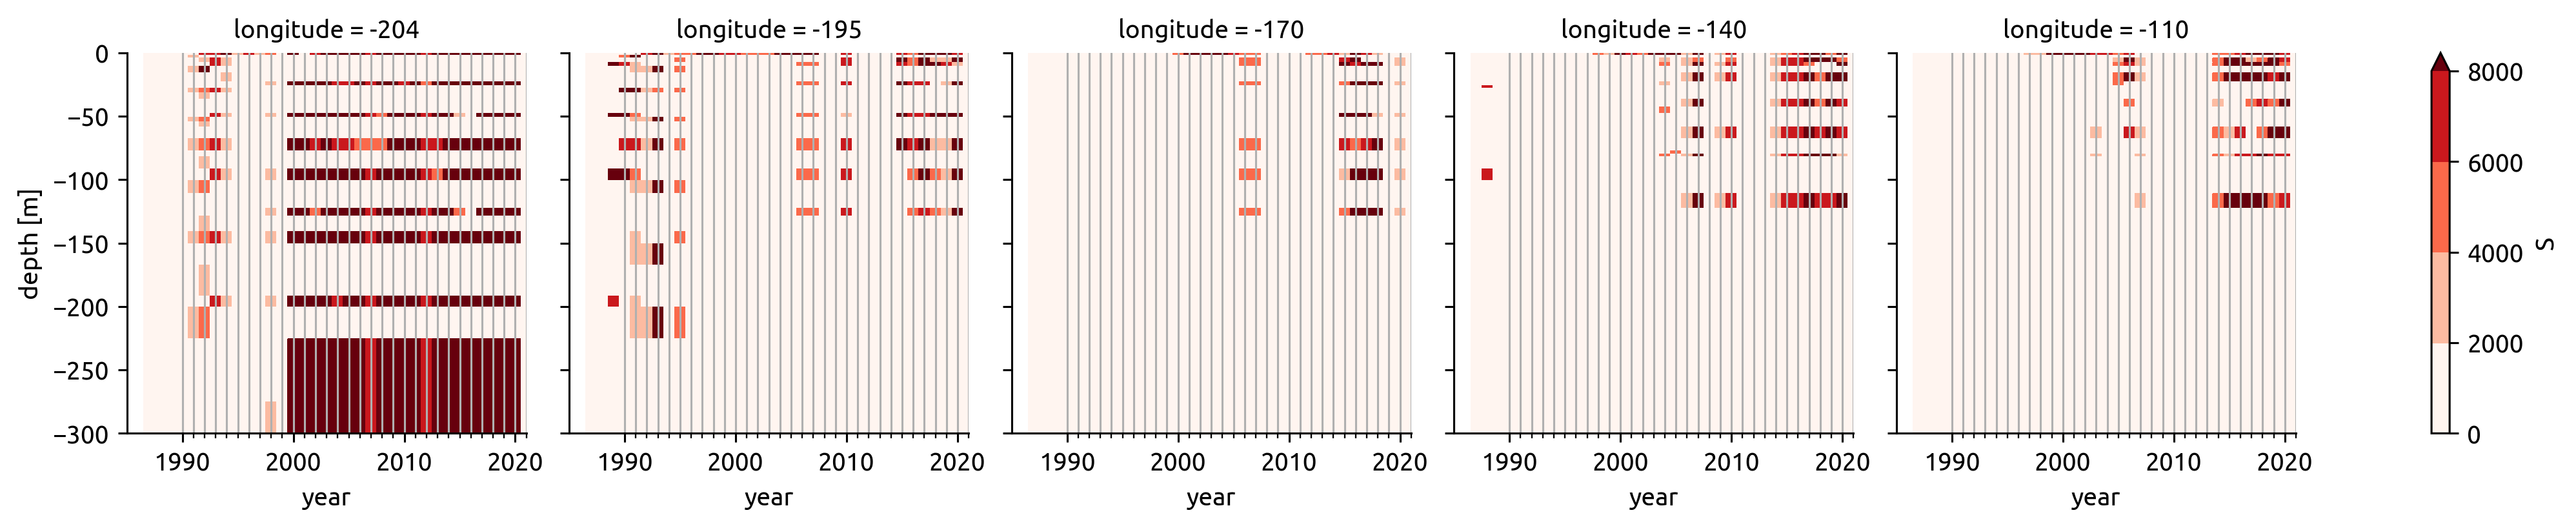

In [261]:
plot_count(salt)

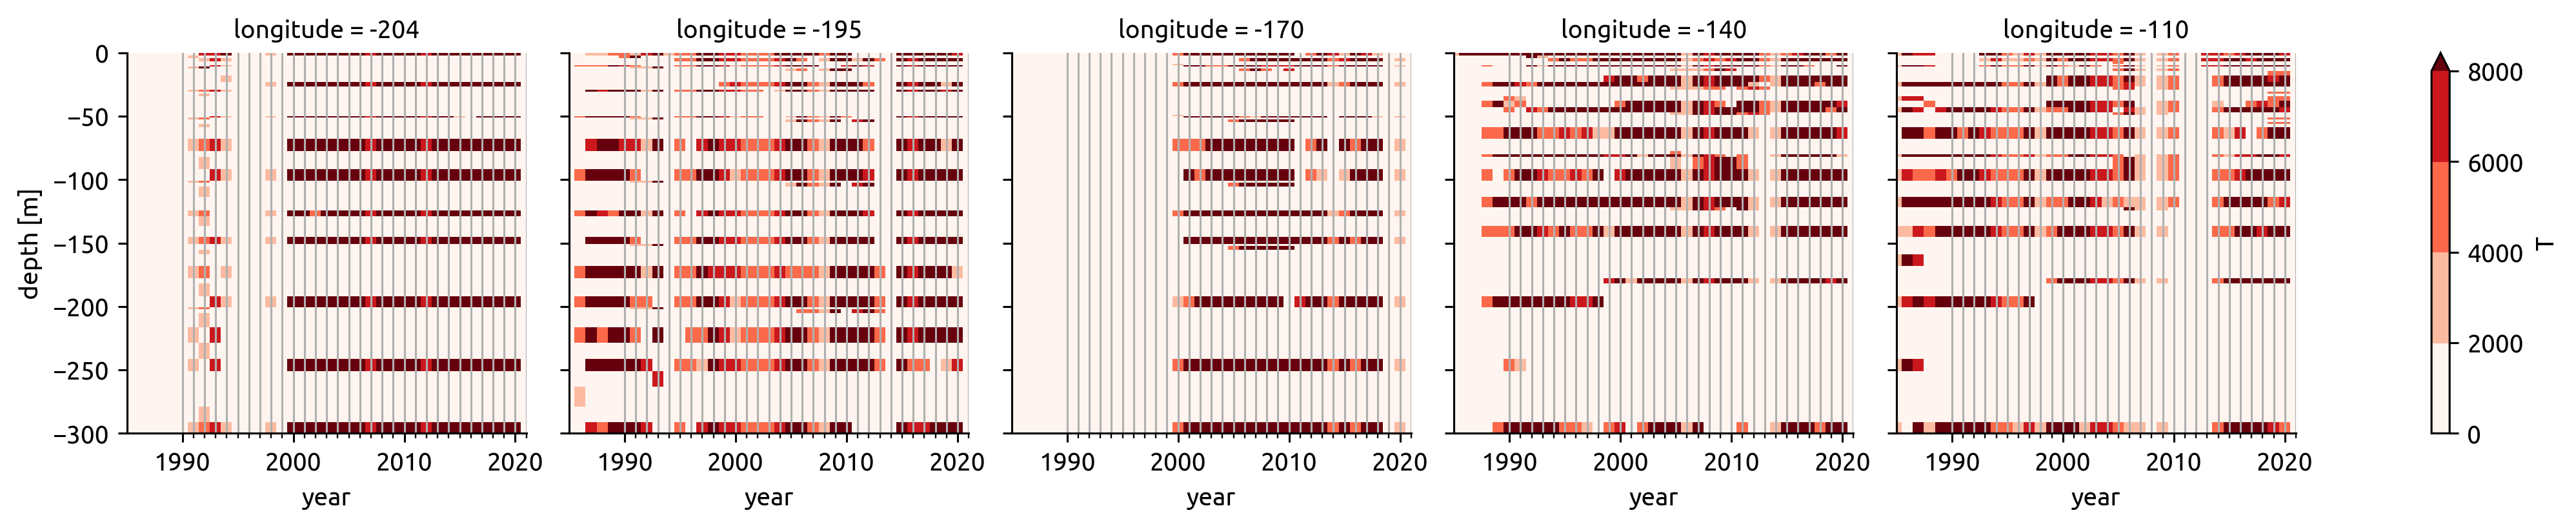

In [259]:
plot_count(temp)

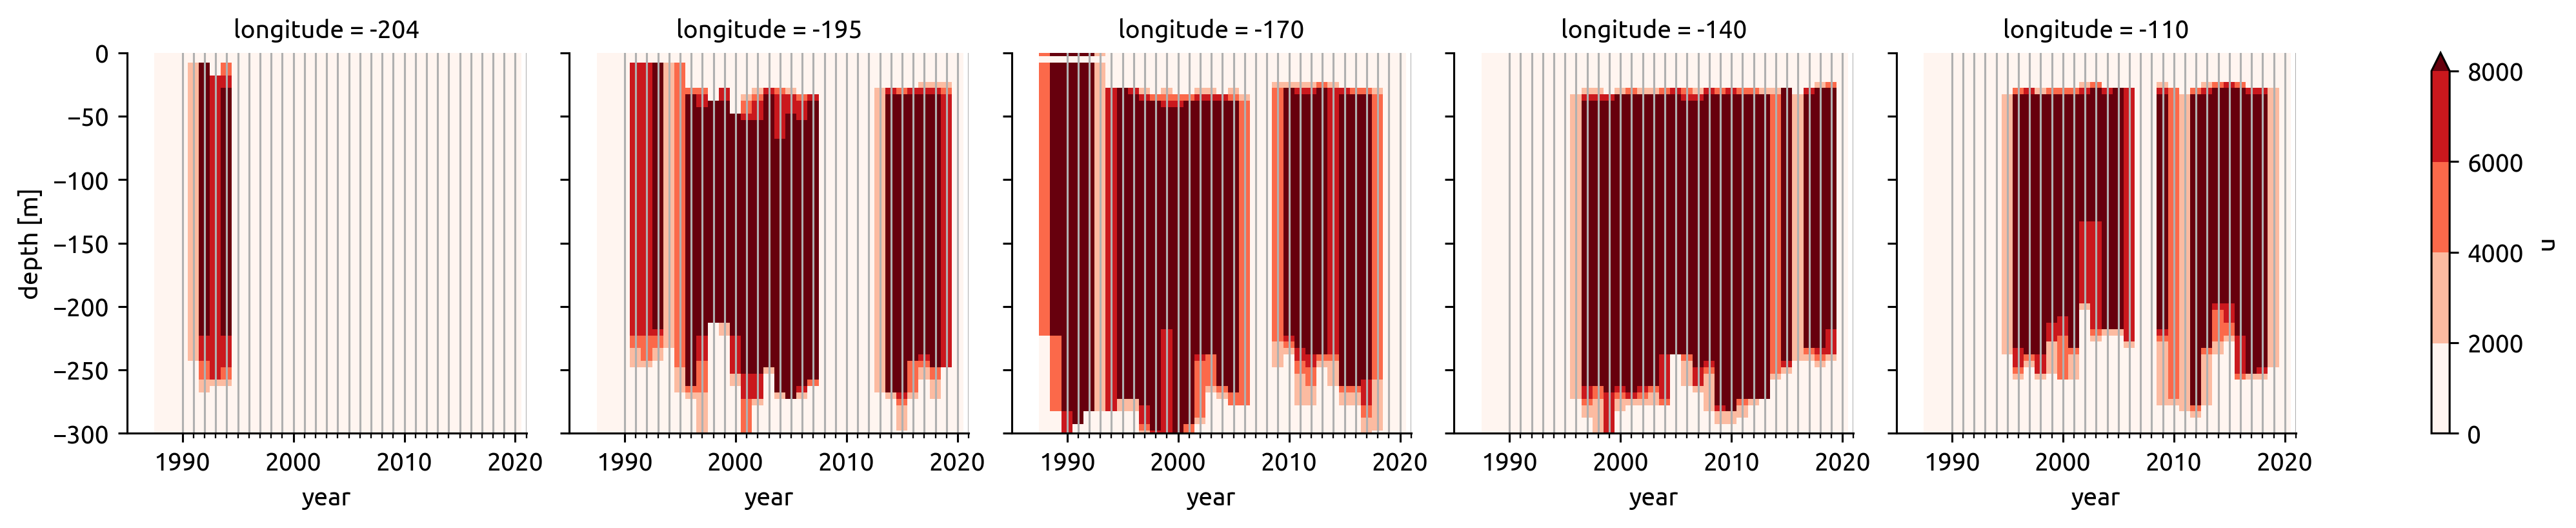

In [260]:
plot_count(adcp.u)

### back to regridding

In [66]:
TS = dask.optimize(
    xr.merge([temp.sel(time=slice("1991", None)), salt.sel(time=slice("1991", None))])
)[0]
binned_temp = (
    TS.groupby_bins("depth", np.arange(-302.5, 3, 5))
    .mean()
    .rename({"depth_bins": "depth"})
    .assign_coords(depth=np.arange(-300, 0.1, 5))
)

# interp using PCHIP to ADCP grid
interp_temp = dcpy.interpolate.pchip(
    binned_temp.chunk({"time": 1000, "depth": -1}),
    "depth",
    adcp.depth,
    core_dim="depth",
)

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/core.py:4241: PerformanceWarning: Increasing number of chunks by factor of 36
  result = blockwise(
/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/core.py:4241: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [44]:
# merged the 10, 25m current meters with ADCP
# prefer ADCP where available
# THIS IS NOT CURRENTLY USED!

hrcur = pump.obs.read_eq_tao_cur_hr()

depth = [-5, -10, -25]  # could add -5?
region = dict(depth=depth)
cur = hrcur.reindex(time=adcp.time).sel(**region)
merged_vel = xr.merge(
    [cur.where(adcp.sel(**region).isnull()), adcp.sel(**region)], compat="no_conflicts"
)

# now add the near-surface stuff with the deeper ADCP stuff
merged_adcp = xr.concat(
    [
        adcp[["u", "v"]].sel(depth=slice(None, -26)),
        merged_vel.sortby("depth", "descending"),
        adcp[["u", "v"]].sel(depth=[-20, -15, 0]),
    ],
    dim="depth",
).sortby("depth", "descending")


# adcp = tao.sel(**region).where(cur.isnull())
# tao_merged = tao.copy().update(merged)
# tao_merged

100%|██████████| 5/5 [00:00<00:00, 76.29it/s]
/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


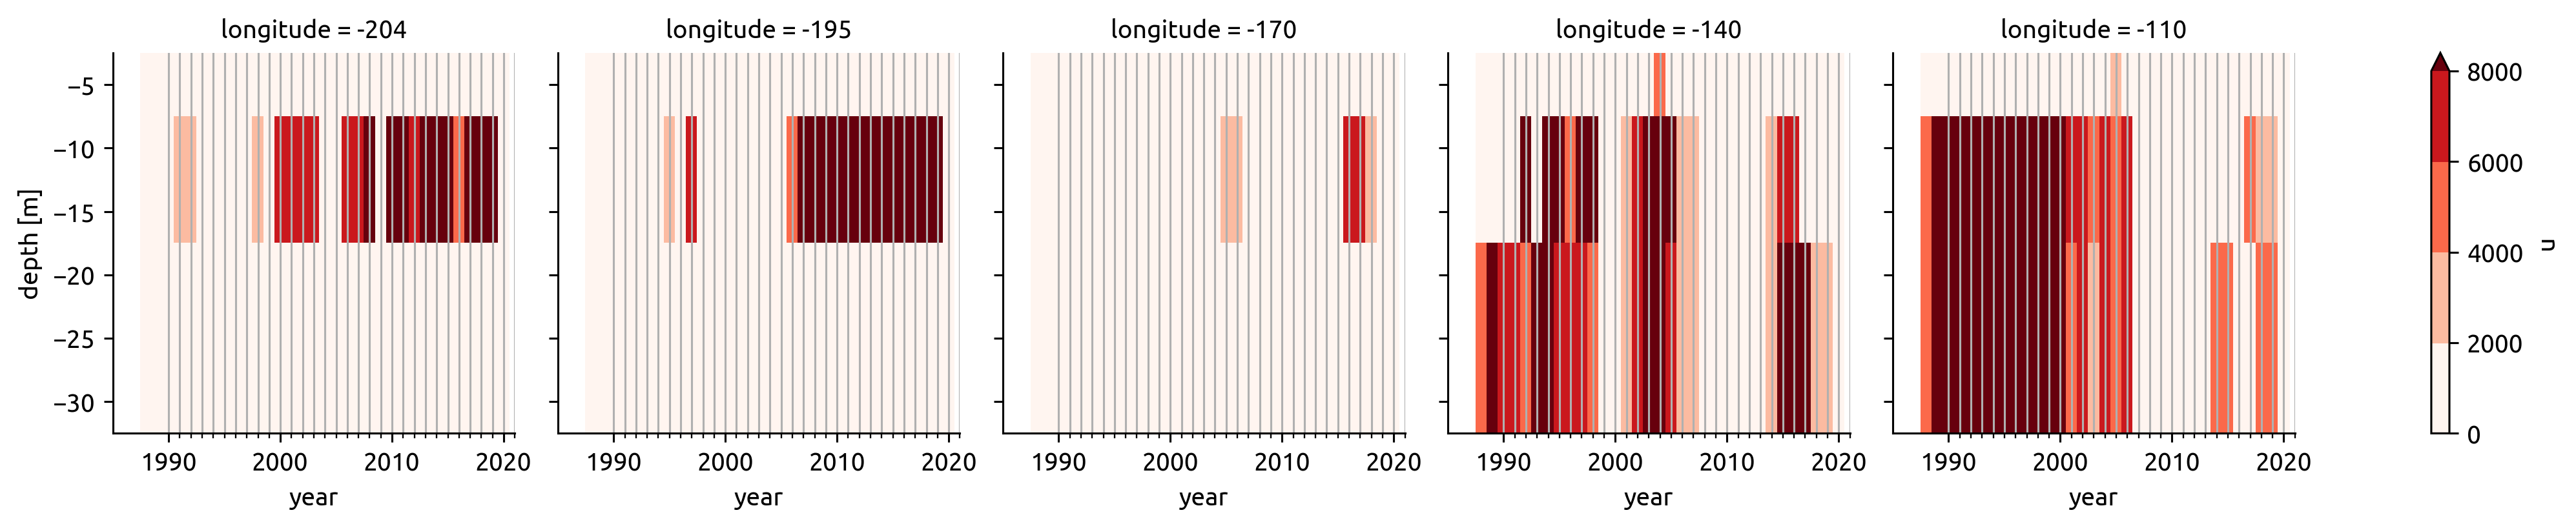

In [45]:
plot_count(hrcur.u.reindex(time=adcp.time).sel(depth=depth))

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


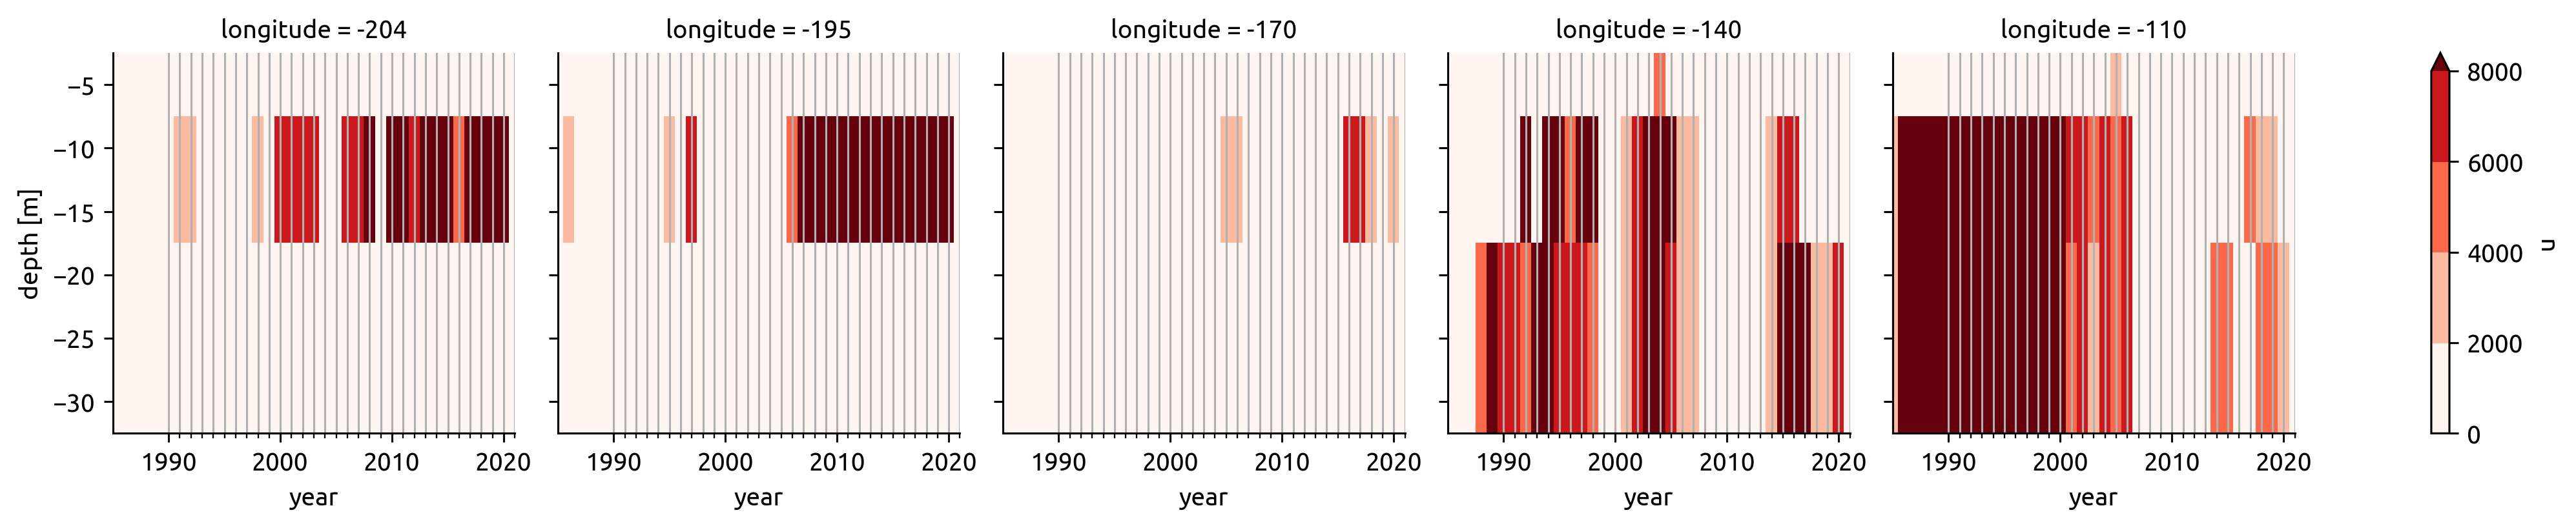

In [46]:
plot_count(hrcur.u.sel(depth=depth))

In [67]:
tao_gridded = xr.merge([interp_temp, adcp])
tao_gridded

<xarray.Dataset>
Dimensions:    (depth: 61, longitude: 5, time: 287335)
Coordinates:
  * time       (time) datetime64[ns] 1988-05-15T18:00:00 ... 2021-02-24
  * depth      (depth) float64 -300.0 -295.0 -290.0 -285.0 ... -10.0 -5.0 0.0
    latitude   float32 0.0
  * longitude  (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
Data variables:
    T          (time, longitude, depth) float64 dask.array<chunksize=(24046, 1, 61), meta=np.ndarray>
    S          (time, longitude, depth) float64 dask.array<chunksize=(24046, 1, 61), meta=np.ndarray>
    u          (time, depth, longitude) float32 dask.array<chunksize=(100000, 21, 1), meta=np.ndarray>
    v          (time, depth, longitude) float32 dask.array<chunksize=(100000, 21, 1), meta=np.ndarray>

In [69]:
tao_gridded.T.attrs = temp.attrs
tao_gridded.S.attrs = salt.attrs

In [74]:
tao_gridded["u"].attrs["standard_name"] = "sea_water_x_velocity"
tao_gridded["v"].attrs["standard_name"] = "sea_water_y_velocity"
tao_gridded["T"].attrs["standard_name"] = "sea_water_temperature"
tao_gridded["S"].attrs["standard_name"] = "sea_water_salinity"
tao_gridded["depth"].attrs = {"positive": "up", "axis": "Z"}
tao_gridded

<xarray.Dataset>
Dimensions:    (depth: 61, longitude: 5, time: 287335)
Coordinates:
  * time       (time) datetime64[ns] 1988-05-15T18:00:00 ... 2021-02-24
  * depth      (depth) float64 -300.0 -295.0 -290.0 -285.0 ... -10.0 -5.0 0.0
    latitude   float32 0.0
  * longitude  (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
Data variables:
    T          (time, longitude, depth) float64 dask.array<chunksize=(24046, 1, 61), meta=np.ndarray>
    S          (time, longitude, depth) float64 dask.array<chunksize=(24046, 1, 61), meta=np.ndarray>
    u          (time, depth, longitude) float32 dask.array<chunksize=(100000, 21, 1), meta=np.ndarray>
    v          (time, depth, longitude) float32 dask.array<chunksize=(100000, 21, 1), meta=np.ndarray>

In [104]:
tao_gridded.chunk({"longitude": 1, "time": 100000, "depth": -1}).to_zarr(
    "tao_eq_hr_gridded.zarr", mode="w", consolidated=True
)

## TAO gridded with ancillary data

In [44]:
tao = pump.obs.read_tao_zarr("gridded")
tao = pump.calc_tao_ri(tao)
tao.coords["mld"] = pump.calc.get_mld_tao(tao.densT)
tao

<xarray.Dataset>
Dimensions:             (depth: 61, longitude: 5, time: 287335)
Coordinates:
  * depth               (depth) float64 -300.0 -295.0 -290.0 ... -10.0 -5.0 0.0
    latitude            float32 0.0
  * longitude           (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
  * time                (time) datetime64[ns] 1988-05-15T18:00:00 ... 2021-02-24
    reference_pressure  int64 0
    mld                 (time, longitude) float64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
Data variables:
    S                   (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    T                   (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    u                   (time, depth, longitude) float32 dask.array<chunksize=(100000, 61, 1), meta=np.ndarray>
    v                   (time, depth, longitude) float32 dask.array<chunksize=(100000, 61, 1), meta=np.ndarray>
    densT               (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    dens                (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    N2                  (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    N2T                 (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    Rig_T               (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    Ri                  (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    S2                  (time, depth, longitude) float32 dask.array<chunksize=(100000, 61, 1), meta=np.ndarray>

## Make masks

### MLD calculation

- [ ] filter Ri by N²

In [7]:
sst = tao.T.sel(depth=[-5, 0]).max("depth")  # account for temperature inversions
diff = (tao.T - sst).isel(depth=slice(None, -1))  # MLD at least 5m
mld_old = diff.depth.where(diff < -0.02).max("depth")
mld_old.load()

<xarray.DataArray 'depth' (time: 287335, longitude: 5)>
array([[ nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan],
       ...,
       [-40., -20., -15.,  -5., -10.],
       [-40., -10., -10.,  -5., -10.],
       [-40., -10., -10.,  -5., -10.]])
Coordinates:
    latitude            float32 0.0
    reference_pressure  int64 0
  * longitude           (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
  * time                (time) datetime64[ns] 1988-05-15T18:00:00 ... 2021-02-24
    mld                 (time, longitude) float64 nan nan nan ... 0.0 -10.0

In [8]:
sub = tao.sel(longitude=-195, time="2015").load()

In [9]:
sub.coords["mld"] = pump.calc.get_mld_tao(sub.densT).load()

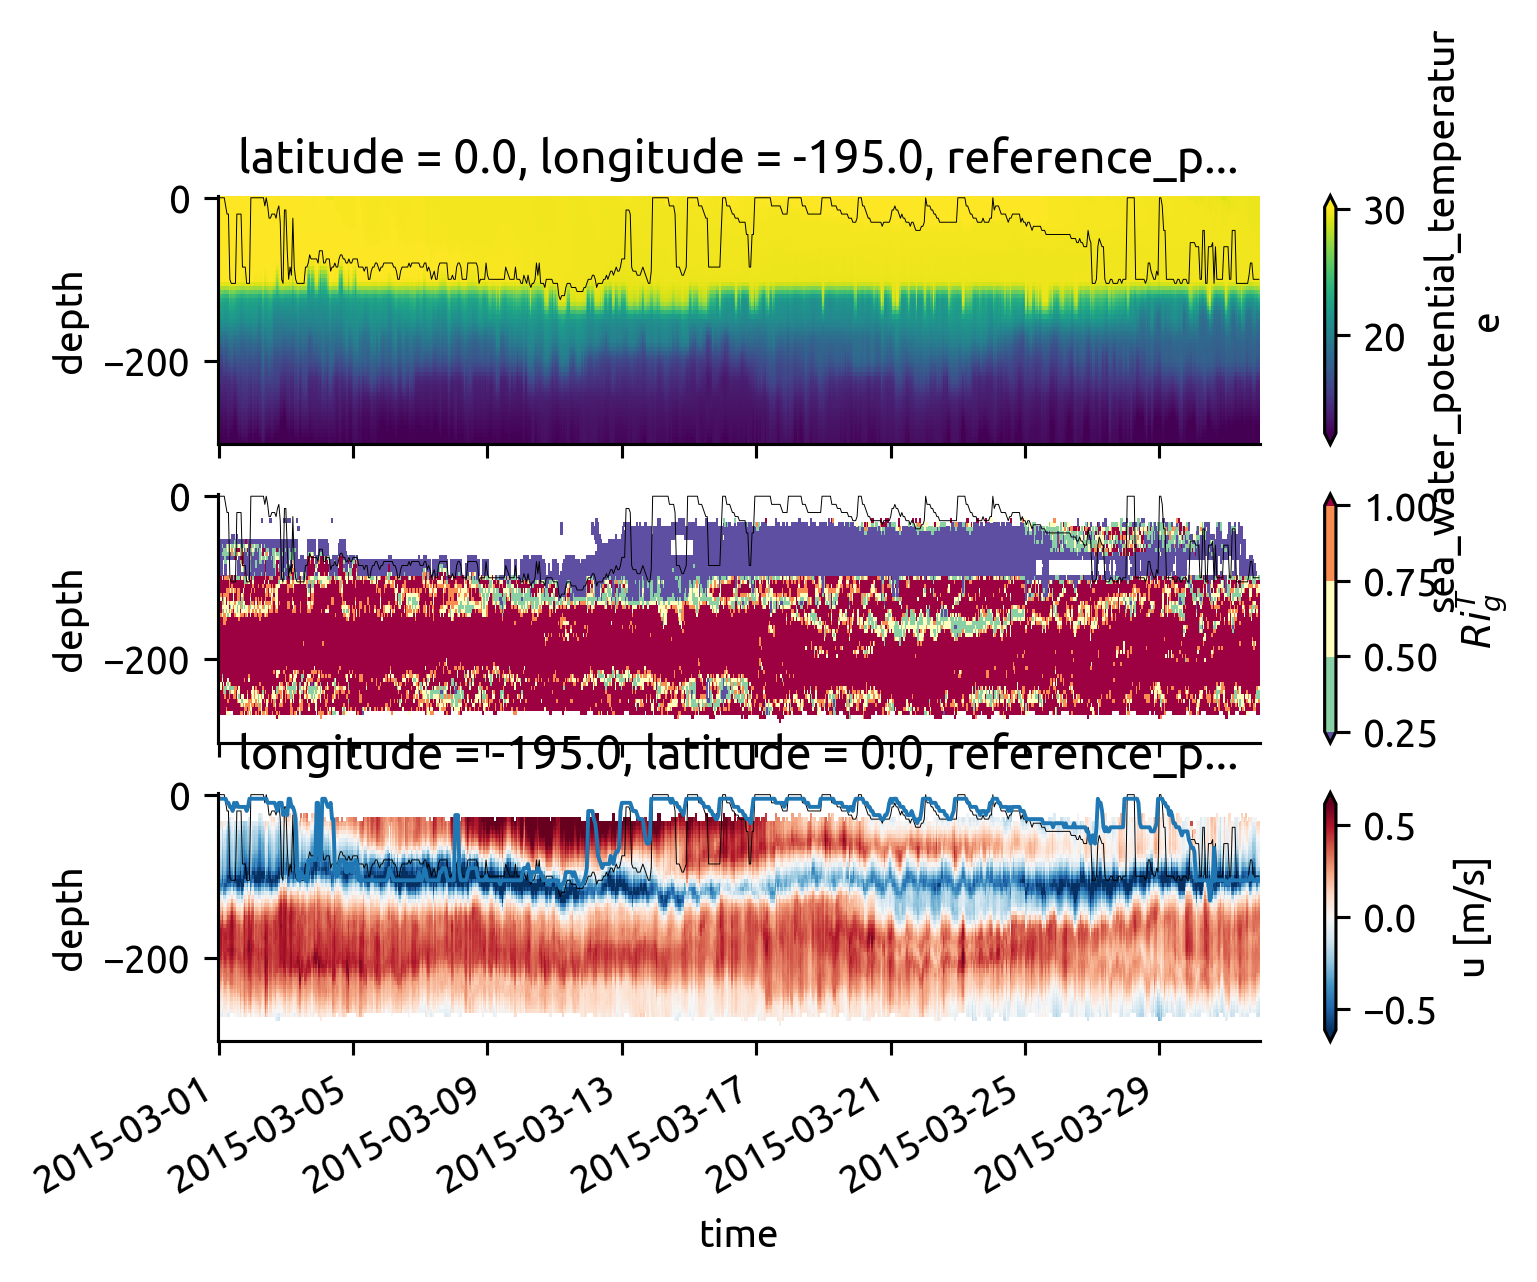

In [18]:
pump.plot.plot_Rig_u(sub.sel(time="2015-Mar"))
mld_old.reindex_like(sub.expand_dims("longitude")).squeeze().sel(time="2015-Mar").plot(x="time")

-10.0
-15.0


[Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, '')]

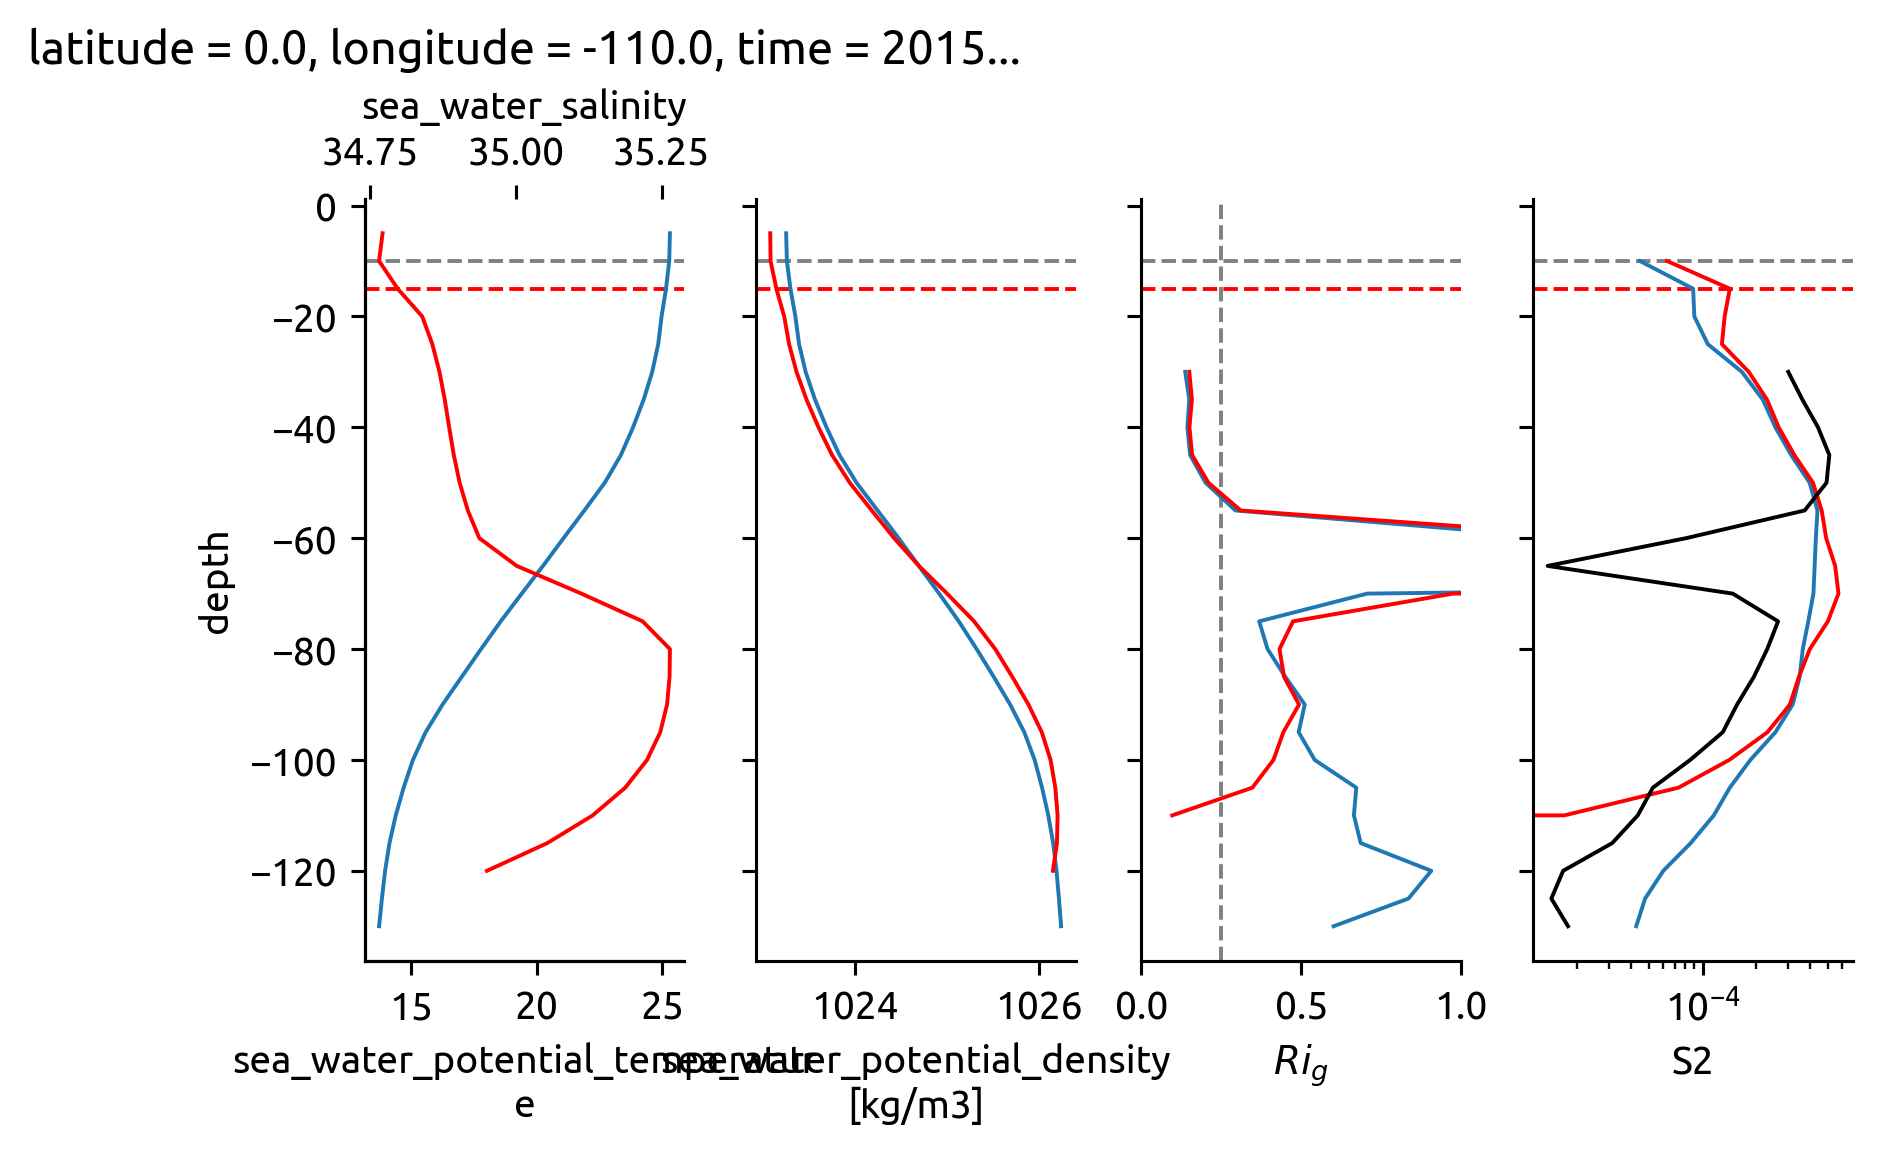

In [48]:
region = dict(longitude=-110, time="2015-03-10 12:00")

sub = tao.sel(**region, depth=slice(-130, None)).compute()
newmld = pump.calc.get_mld_tao(sub.densT)

print(mld_old.sel(region).values)
print(newmld.values)

f, ax = plt.subplots(1, 4, sharey=True, constrained_layout=True)

sub.T.plot(ax=ax[0], y="depth")
sub.S.plot(ax=ax[0].twiny(), color="r", y="depth")

sub.densT.plot(ax=ax[1], y="depth")
sub.dens.plot(ax=ax[1], color="r", y="depth")
sub.Rig_T.plot(ax=ax[2], xlim=(0, 1), y="depth")
sub.Ri.plot(ax=ax[2], xlim=(0, 1), y="depth", color="r")
dcpy.plots.linex(0.25, ax[2])

sub.N2T.plot(ax=ax[3], y="depth", xscale="log")
sub.N2.plot(ax=ax[3], color="r", y="depth", xscale="log")
(sub.S2/4).plot(ax=ax[3], color="k", y="depth")

for axx in ax.flat:
    dcpy.plots.liney(mld_old.sel(region), ax=axx)
    dcpy.plots.liney(newmld, color="r", ax=axx)

dcpy.plots.clean_axes(ax)
[axx.set_title("") for axx in ax]
# dcpy.plots.linex(0)

### depth of shallowest measurement

Need OK estimate of SST. This doesn't affect the end result but still a nice thing to do.

In [204]:
shallowest = tao.depth.where(tao.T.notnull()).ffill("depth").isel(depth=-1)
shallowest.attrs["description"] = "Shallowest depth with a valid observation"

### Depth of deepest measurement

Maybe I want to only keep places where I have a bunch of data?

In [205]:
# deepest depth with valid measurement
# This is quite crude: what if the 500m instrument works but nothing above 100m works...
deepest = tao.T.depth.where(tao.T.notnull()).min("depth")
deepest.attrs["description"] = "Deepest depth with a valid observation"

### Temperature mask criterion for EUCmax

In [208]:
# mask so that we get reasonable eucmax values.
# and don't get fooled by large near-surface velocities.
eucmask = xr.concat(
    [
        tao.T.reset_coords(drop=True).sel(longitude=-204) < 23.5,
        tao.T.reset_coords(drop=True).sel(longitude=-195) < 23.5,
        xr.full_like(tao.T.reset_coords(drop=True).sel(longitude=-170), fill_value=True),
        xr.full_like(tao.T.reset_coords(drop=True).sel(longitude=-140), fill_value=True),
        xr.full_like(tao.T.reset_coords(drop=True).sel(longitude=-110), fill_value=True),
    ],
    "longitude",
)

# number of T, U measurements
nT = tao.T.count("depth")
nU = tao.u.count("depth")
eucmax = pump.get_euc_max(
    tao.u
    .where(eucmask)
    .where((deepest < -35) & (nT > 4) & (nU > 10))
    .pipe(dcpy.interpolate.pchip_fillna, "depth")
    .reset_coords(drop=True),
    kind="data",
)

# fix 1997-1998 at -110
region = dict(longitude=-110)
eucmax_reg = eucmax.sel(**region)
ueuc = tao.u.sel(depth=eucmax_reg.fillna(0), **region).where(eucmax_reg)
eucmax = xr.concat(
    [
        eucmax.sel(longitude=slice(-140)),
        eucmax.sel(longitude=[-110]).where(ueuc > 0.4),
    ],
    dim="longitude",
)
eucmax

<xarray.DataArray 'depth' (time: 287335, longitude: 5)>
dask.array<concatenate, shape=(287335, 5), dtype=float64, chunksize=(287335, 4), chunktype=numpy.ndarray>
Coordinates:
    latitude            float32 0.0
    mld                 (time) float64 dask.array<chunksize=(100000,), meta=np.ndarray>
    depth               (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    reference_pressure  int64 0
  * time                (time) datetime64[ns] 1988-05-15T18:00:00 ... 2021-02-24
  * longitude           (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
Attributes:
    long_name:  Depth of EUC max
    units:      m

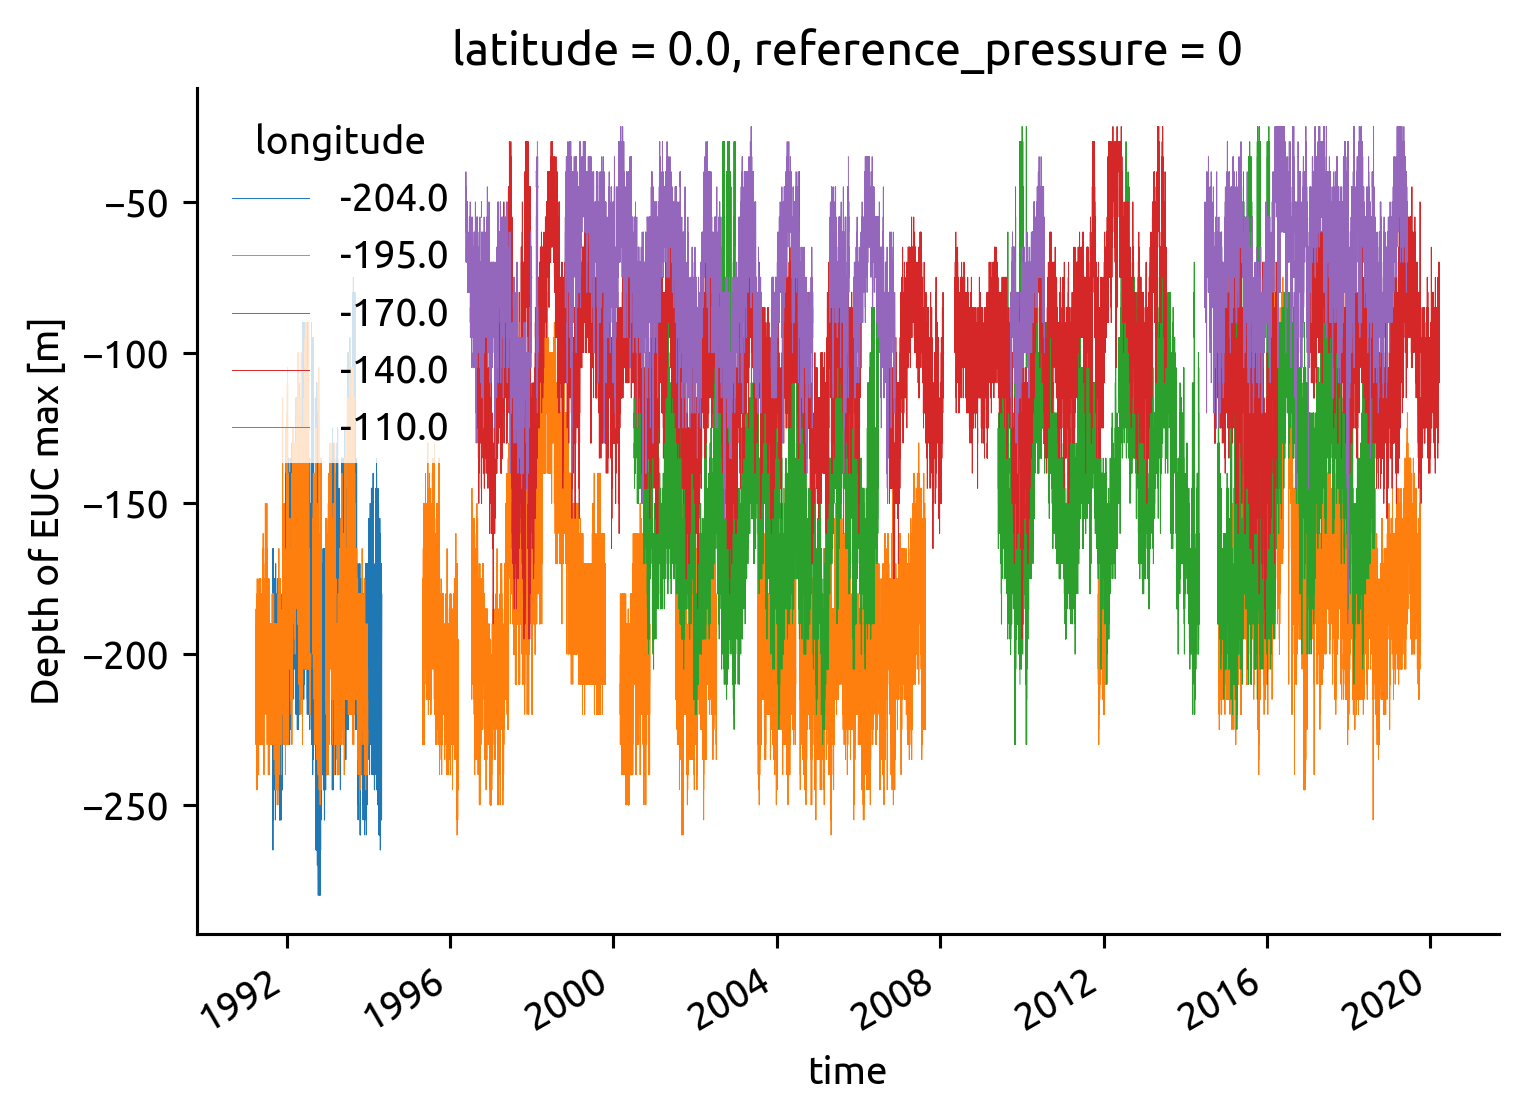

In [215]:
eucmax.plot.line(x="time", lw=0.25)

### Assign mask variables as coords

In [218]:
tao = tao.assign_coords(
    eucmax=eucmax.reset_coords(drop=True),
    # mld=mld.reset_coords(drop=True),
    deepest=deepest.reset_coords(drop=True),
    shallowest=shallowest.reset_coords(drop=True),
    zeuc=tao.depth - eucmax.reset_coords(drop=True),
)
tao

<xarray.Dataset>
Dimensions:             (depth: 61, longitude: 5, time: 287335)
Coordinates:
  * depth               (depth) float64 -300.0 -295.0 -290.0 ... -10.0 -5.0 0.0
    latitude            float32 0.0
  * longitude           (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
  * time                (time) datetime64[ns] 1988-05-15T18:00:00 ... 2021-02-24
    reference_pressure  int64 0
    mld                 (time, longitude) float64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    eucmax              (time, longitude) float64 dask.array<chunksize=(287335, 4), meta=np.ndarray>
    deepest             (time, longitude) float64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    shallowest          (time, longitude) float64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    zeuc                (depth, time, longitude) float64 dask.array<chunksize=(61, 287335, 4), meta=np.ndarray>
Data variables:
    S                   (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    T                   (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    u                   (time, depth, longitude) float32 dask.array<chunksize=(100000, 61, 1), meta=np.ndarray>
    v                   (time, depth, longitude) float32 dask.array<chunksize=(100000, 61, 1), meta=np.ndarray>
    densT               (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    dens                (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    N2                  (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    N2T                 (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    Rig_T               (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    Ri                  (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    S2                  (time, depth, longitude) float32 dask.array<chunksize=(100000, 61, 1), meta=np.ndarray>

In [219]:
tao["mld"].attrs.update({"long_name": "$z_{MLD}$", "units": "m"})
tao["eucmax"].attrs.update({"long_name": "$z_{EUC}$", "units": "m"})
tao["deepest"].attrs.update({"units": "m"})
tao["shallowest"].attrs.update({"units": "m"})
tao["depth"].attrs.update({"units": "m", "positive": "up", "axis": "Z"})
tao

<xarray.Dataset>
Dimensions:             (depth: 61, longitude: 5, time: 287335)
Coordinates:
  * depth               (depth) float64 -300.0 -295.0 -290.0 ... -10.0 -5.0 0.0
    latitude            float32 0.0
  * longitude           (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
  * time                (time) datetime64[ns] 1988-05-15T18:00:00 ... 2021-02-24
    reference_pressure  int64 0
    mld                 (time, longitude) float64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    eucmax              (time, longitude) float64 dask.array<chunksize=(287335, 4), meta=np.ndarray>
    deepest             (time, longitude) float64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    shallowest          (time, longitude) float64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    zeuc                (depth, time, longitude) float64 dask.array<chunksize=(61, 287335, 4), meta=np.ndarray>
Data variables:
    S                   (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    T                   (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    u                   (time, depth, longitude) float32 dask.array<chunksize=(100000, 61, 1), meta=np.ndarray>
    v                   (time, depth, longitude) float32 dask.array<chunksize=(100000, 61, 1), meta=np.ndarray>
    densT               (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    dens                (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    N2                  (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    N2T                 (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    Rig_T               (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    Ri                  (time, longitude, depth) float64 dask.array<chunksize=(100000, 1, 61), meta=np.ndarray>
    S2                  (time, depth, longitude) float32 dask.array<chunksize=(100000, 61, 1), meta=np.ndarray>

In [220]:
if "_FillValue" in tao.time.encoding:
    del tao.time.encoding["_FillValue"]
for var in tao.variables:
    if "chunks" in tao[var].encoding:
        del tao[var].encoding["chunks"]
tao.to_zarr("tao-gridded-ancillary.zarr", mode="w")

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


### test deepest

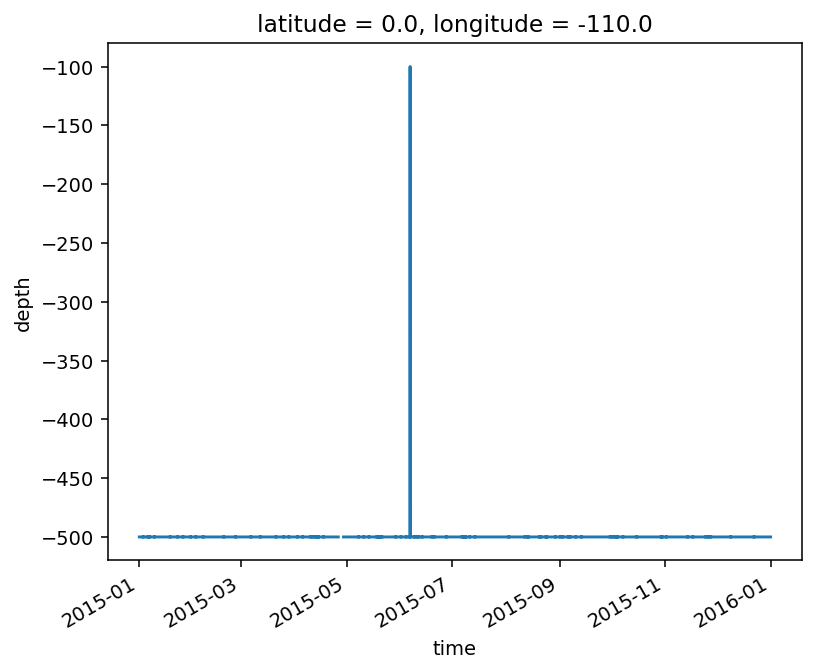

In [158]:
deepest.sel(longitude=-110, time="2015").plot(x="time")

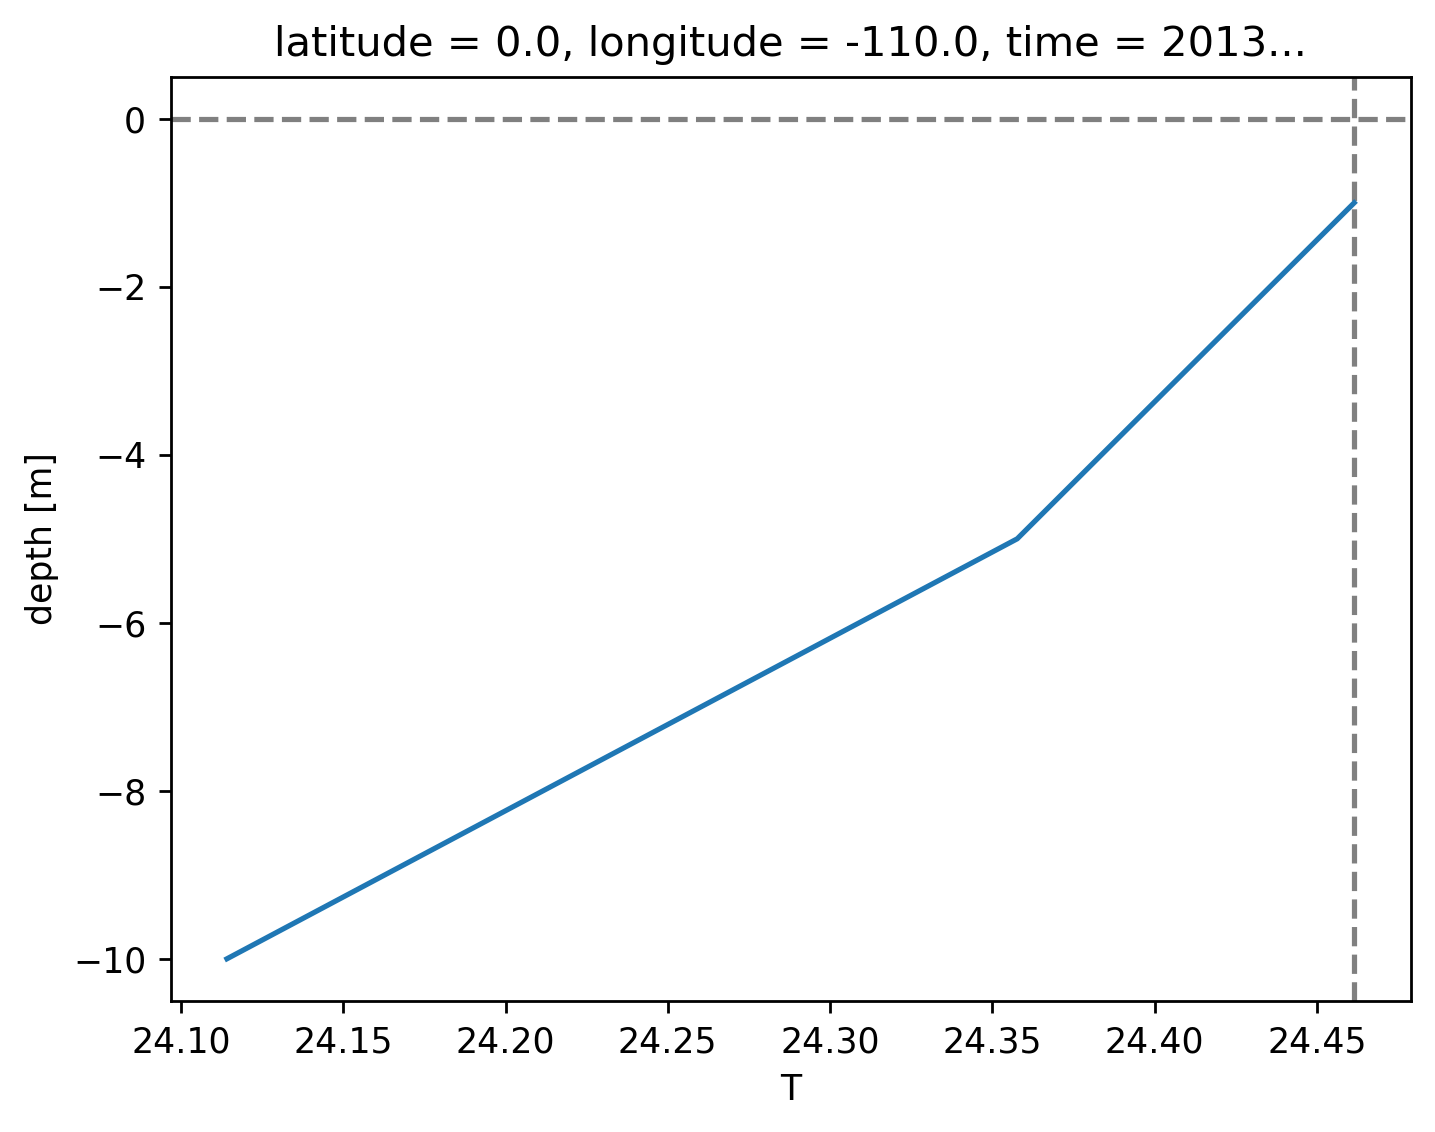

In [8]:
def debug_mld(**region):
    filled.sel(**region).plot(y="depth")
    dcpy.plots.liney(mld.sel(**region))
    dcpy.plots.linex(sst.sel(**region))
    
debug_mld(longitude=-110, time="2013-05-01 00:00")

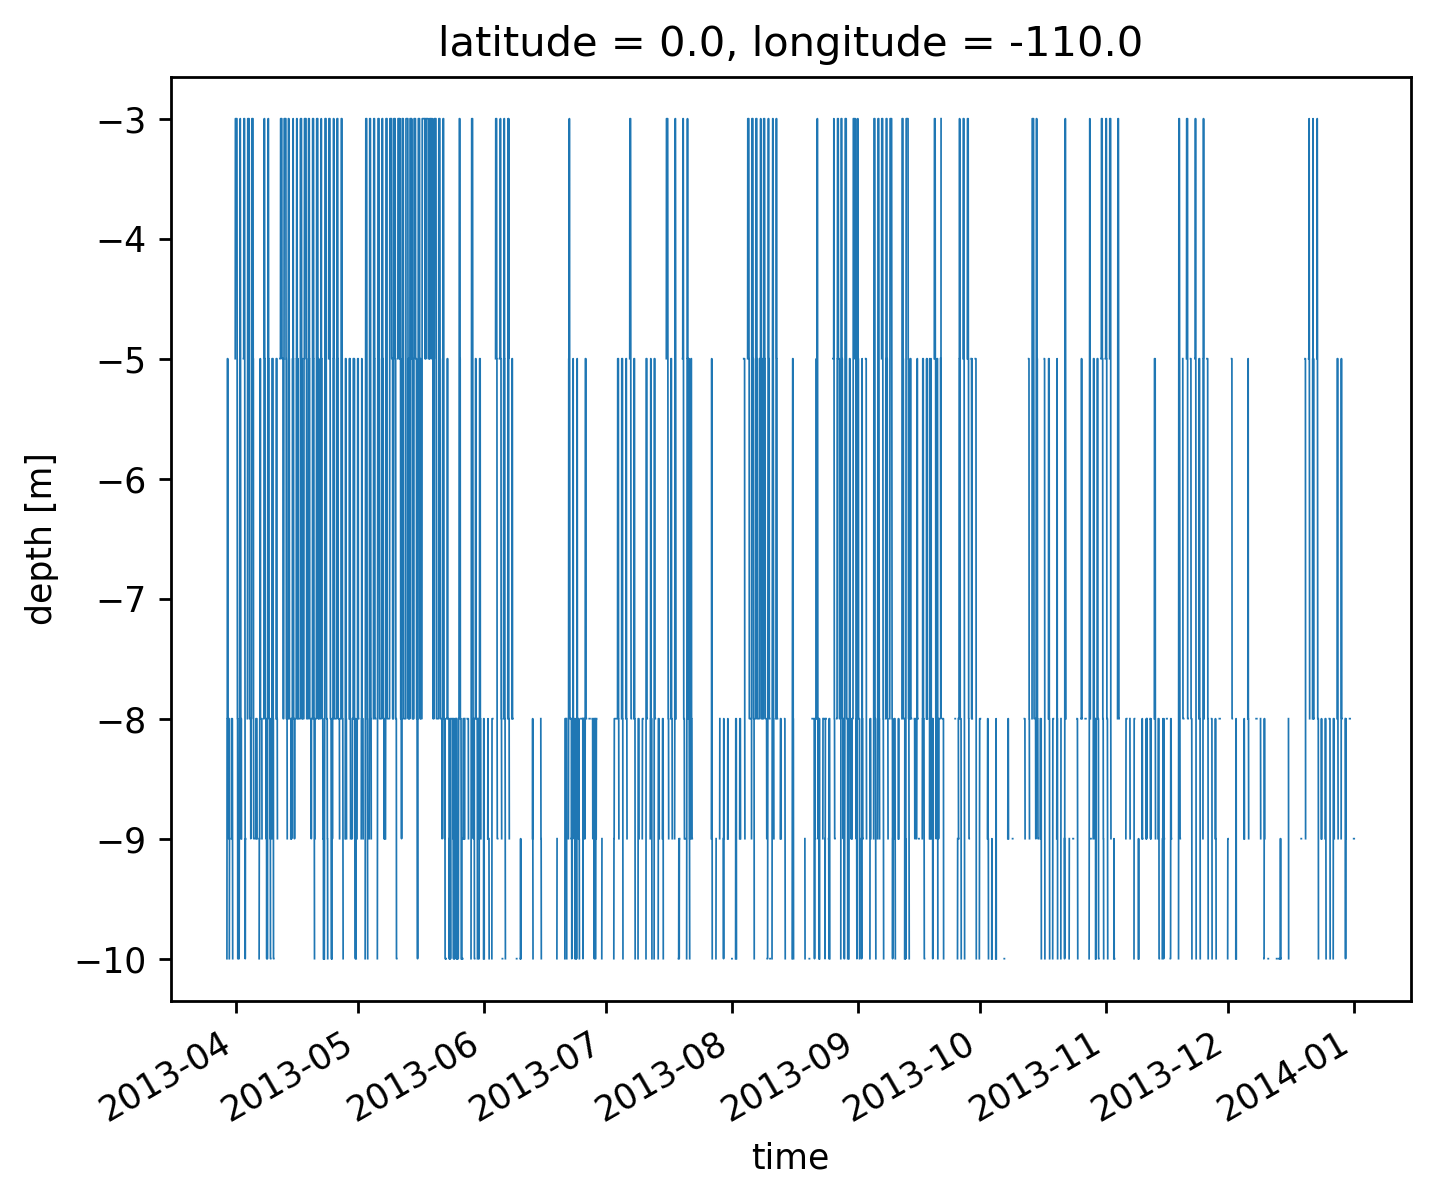

In [177]:
mld.sel(longitude=-110, time="2013").plot(x="time", lw=0.5)

In [35]:
eucmax.sel(longitude=-110).plot(x="time", color='k', lw=1)

In [52]:
tao.u.sel(longitude=-110, time=slice("1996", "2000")).plot(x="time")
eucmax.sel(longitude=-110, time=slice("1996", "2000")).plot(x="time", color='k', lw=1)

In [56]:
plt.figure()
(eucmax.sel(longitude=-170)
.where(ueuc > 0.5)
.sel(time=slice("1996", "2000"))
.plot(x="time", color='k', lw=1))

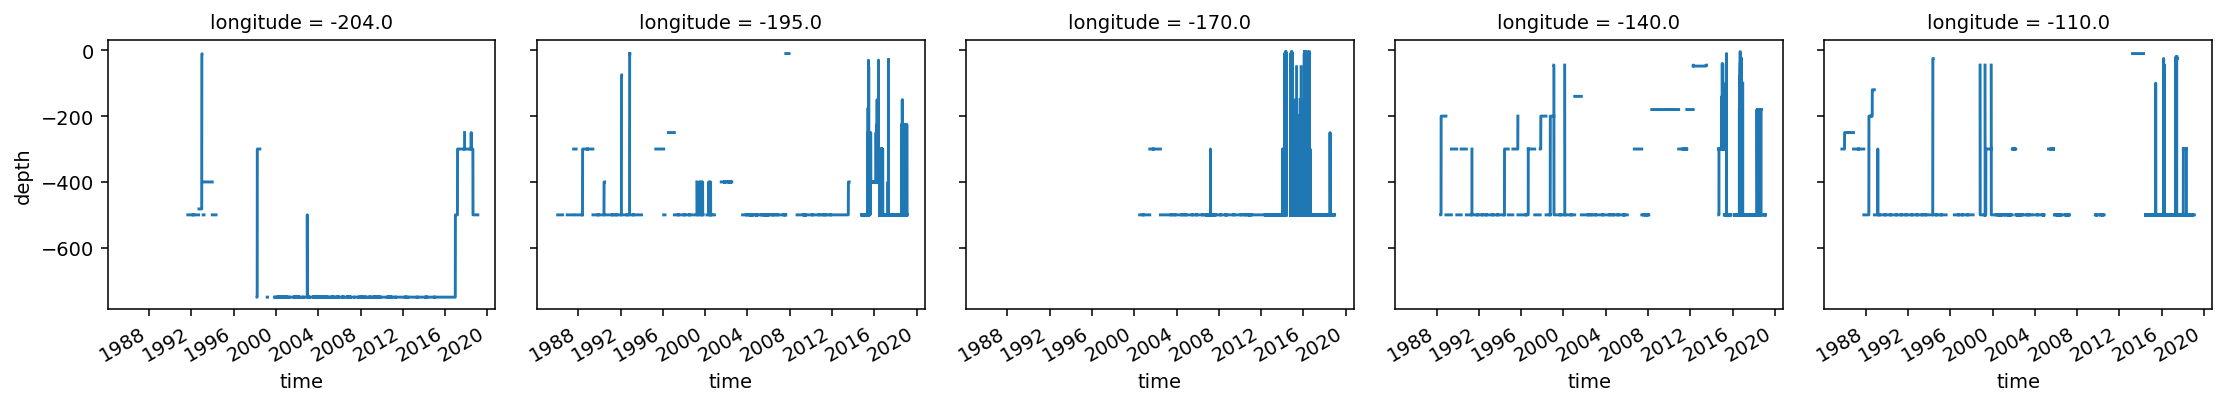

In [106]:
deepest.compute().plot(col="longitude")

In [ ]:
Teuc.sel(longitude=-140).plot()

## TAO in z space: daily avg

In [96]:
tao = pump.obs.read_tao_zarr("ancillary")
tao_clim = tao.mean("time")
tao_clim["eucmax"] = pump.calc.get_euc_max(tao_clim.u)
tao_clim = pump.calc.estimate_euc_depth_terms(tao_clim)
tao_clim.attrs["name"] = "TAO"
tao_clim.load()

<xarray.Dataset>
Dimensions:    (depth: 101, longitude: 5)
Coordinates:
  * depth      (depth) float64 -500.0 -495.0 -490.0 -485.0 ... -10.0 -5.0 0.0
    latitude   float32 0.0
  * longitude  (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
Data variables: (12/16)
    Rig        (longitude, depth) float64 nan nan nan nan ... nan nan nan nan
    T          (longitude, depth) float64 8.177 8.225 8.277 ... 24.14 24.22
    dens       (longitude, depth) float64 1.025e+03 1.025e+03 ... 1.024e+03
    u          (depth, longitude) float32 nan nan -0.0465 ... -0.2404 nan nan
    v          (depth, longitude) float32 nan nan -0.0385 ... -0.06971 nan nan
    eucmax     (longitude) float64 -200.0 -190.0 -155.0 -105.0 -75.0
    ...         ...
    dens_euc   (longitude) float64 1.025e+03 1.024e+03 ... 1.024e+03 1.025e+03
    b          (longitude, depth) float64 -9.814 -9.814 -9.814 ... -9.797 -9.797
    bs         (longitude) float64 -9.783 -9.786 -9.795 -9.8 -9.798
    beuc       (longitude) float64 -9.81 -9.81 -9.81 -9.81 -9.81
    db         (longitude) float64 0.02696 0.02448 0.01489 0.0098 0.01156
    Rib        (longitude) float64 32.89 12.03 3.292 0.897 1.094
Attributes:
    name:     TAO

## TAO in EUC space

In [3]:
tao = pump.obs.read_tao_zarr("ancillary", chunks={"time": 5000})
#tao["Rig"] = pump.calc_tao_ri(tao[["u", "v"]], tao["T"])
tao

/home/deepak/work/python/xarray/xarray/core/dataset.py:413: UserWarning: Specified Dask chunks (5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 2335) would separate on disks chunk shape 100000 for dimension time. This could degrade performance. Consider rechunking after loading instead.
  _check_chunks_compatibility(var, output_chunks, preferred_chunks)
/home/deepak/work/python/xarray/xarray/core/dataset.py:413: UserWarning: Specified Dask chunks (5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 50

<xarray.Dataset>
Dimensions:             (depth: 61, longitude: 5, time: 287335)
Coordinates:
    deepest             (time, longitude) float64 dask.array<chunksize=(5000, 1), meta=np.ndarray>
  * depth               (depth) float64 -300.0 -295.0 -290.0 ... -10.0 -5.0 0.0
    eucmax              (time, longitude) float64 dask.array<chunksize=(5000, 4), meta=np.ndarray>
    latitude            float32 ...
  * longitude           (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
    mld                 (time, longitude) float64 dask.array<chunksize=(5000, 1), meta=np.ndarray>
    reference_pressure  int64 ...
    shallowest          (time, longitude) float64 dask.array<chunksize=(5000, 1), meta=np.ndarray>
  * time                (time) datetime64[ns] 1988-05-15T18:00:00 ... 2021-02-24
    zeuc                (depth, time, longitude) float64 dask.array<chunksize=(61, 5000, 4), meta=np.ndarray>
Data variables:
    N2                  (time, longitude, depth) float64 dask.array<chunksize=(5000, 1, 61), meta=np.ndarray>
    N2T                 (time, longitude, depth) float64 dask.array<chunksize=(5000, 1, 61), meta=np.ndarray>
    Ri                  (time, longitude, depth) float64 dask.array<chunksize=(5000, 1, 61), meta=np.ndarray>
    Rig_T               (time, longitude, depth) float64 dask.array<chunksize=(5000, 1, 61), meta=np.ndarray>
    S                   (time, longitude, depth) float64 dask.array<chunksize=(5000, 1, 61), meta=np.ndarray>
    S2                  (time, depth, longitude) float32 dask.array<chunksize=(5000, 61, 1), meta=np.ndarray>
    T                   (time, longitude, depth) float64 dask.array<chunksize=(5000, 1, 61), meta=np.ndarray>
    dens                (time, longitude, depth) float64 dask.array<chunksize=(5000, 1, 61), meta=np.ndarray>
    densT               (time, longitude, depth) float64 dask.array<chunksize=(5000, 1, 61), meta=np.ndarray>
    u                   (time, depth, longitude) float32 dask.array<chunksize=(5000, 61, 1), meta=np.ndarray>
    v                   (time, depth, longitude) float32 dask.array<chunksize=(5000, 61, 1), meta=np.ndarray>

In [292]:
good_data = tao.where(
    (tao.depth < tao.mld)  # & (tao.deepest < -100) # & (tao.shallowest > -15)
)

interped = dcpy.interpolate.bin_to_new_coord(
    good_data.chunk({"depth": -1}),
    old_coord="depth",
    new_coord="zeuc",
    edges=np.arange(-50, 250, 5),
)

check that things look OK

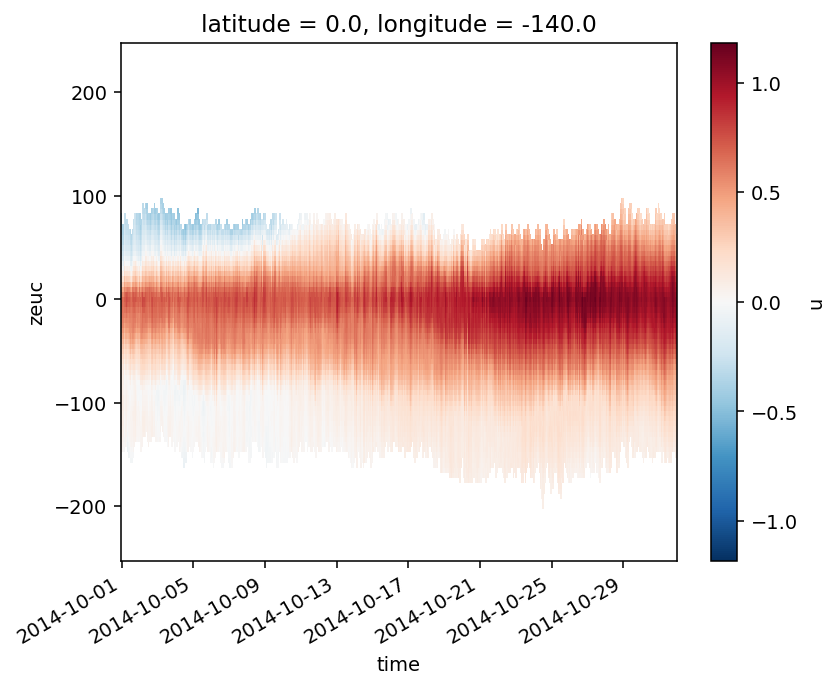

In [160]:
interped.u.sel(time="2014-Oct", longitude=-140).compute().plot(x="time")

In [326]:
interped.time.encoding.pop("_FillValue", None)
for var in interped.variables:
    interped[var].encoding.pop("chunks", None)
interped.to_zarr("tao-zeuc.zarr", mode="w", consolidated=True)

## Seasonal mean Ri profile in EUC space

Interpolate:
1. fill NaNs with pchip
2. isolate to below mixed layer
    1. where we have a reasonable estimate of sst
    2. deep enough instrument coverage
3. Linearly interpolate to a 5m grid
    
    
I really should just be binning in an EUC-relative coordinate, so it's the same Ri numbers just presented differently

In [4]:
interped = xr.open_zarr("tao-zeuc.zarr")
interped

<xarray.Dataset>
Dimensions:             (longitude: 5, time: 287335, zeuc: 59)
Coordinates:
    deepest             (time, longitude) float64 dask.array<chunksize=(5000, 1), meta=np.ndarray>
    eucmax              (time, longitude) float64 dask.array<chunksize=(5000, 4), meta=np.ndarray>
    latitude            float32 ...
  * longitude           (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
    mld                 (time, longitude) float64 dask.array<chunksize=(5000, 1), meta=np.ndarray>
    reference_pressure  int64 ...
    shallowest          (time, longitude) float64 dask.array<chunksize=(5000, 1), meta=np.ndarray>
  * time                (time) datetime64[ns] 1988-05-15T18:00:00 ... 2021-02-24
  * zeuc                (zeuc) float64 -47.5 -42.5 -37.5 ... 232.5 237.5 242.5
Data variables:
    N2                  (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    N2T                 (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    Ri                  (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    Rig_T               (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    S                   (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    S2                  (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    T                   (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    dens                (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    densT               (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    u                   (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>
    v                   (time, longitude, zeuc) float64 dask.array<chunksize=(5000, 1, 59), meta=np.ndarray>

In [346]:
grouped = (
    interped[["Rig_T", "Ri"]]
    .chunk({"time": -1, "zeuc": 10})
    .load()
    .groupby("time.season")
)

Ri_q = grouped.quantile(dim="time", q=[0.25, 0.5, 0.75]).reindex(
    season=["DJF", "MAM", "JJA", "SON"]
)

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [347]:
Ri_q.coords.update(grouped.count("time").rename({"Rig_T": "num_Rig_T", "Ri": "num_Rig"}))
Ri_q.zeuc.attrs["long_name"] = "Depth relative to EUC max"
Ri_q.zeuc.attrs["units"] = "m"
Ri_q

<xarray.Dataset>
Dimensions:             (longitude: 5, quantile: 3, season: 4, zeuc: 59)
Coordinates:
  * season              (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * longitude           (longitude) float64 -204.0 -195.0 -170.0 -140.0 -110.0
  * zeuc                (zeuc) float64 -47.5 -42.5 -37.5 ... 232.5 237.5 242.5
  * quantile            (quantile) float64 0.25 0.5 0.75
    num_Rig_T           (season, longitude, zeuc) int64 2949 3436 3665 ... 0 0 0
    num_Rig             (season, longitude, zeuc) int64 169 352 545 ... 0 0 0
    latitude            float32 0.0
    reference_pressure  int64 0
Data variables:
    Rig_T               (season, quantile, longitude, zeuc) float64 0.9478 .....
    Ri                  (season, quantile, longitude, zeuc) float64 1.982 ......

In [348]:
Ri_q.to_netcdf("tao-hourly-Ri-seasonal-percentiles-2.nc")

## 20 year Stations to zarr

In [1]:
import ncar_jobqueue

if "client" in locals():
    client.close()
if "cluster" in locals():
    cluster.close()

env = {"OMP_NUM_THREADS": "3", "NUMBA_NUM_THREADS": "3"}

# cluster = distributed.LocalCluster(
#    n_workers=8,
#    threads_per_worker=1,
#    env=env
# )

if "cluster" in locals():
    del cluster

cluster = ncar_jobqueue.NCARCluster(
    project="NCGD0046",
    scheduler_options=dict(dashboard_address=":9898"),
)
# cluster = dask_jobqueue.PBSCluster(
#    cores=9, processes=9, memory="108GB", walltime="02:00:00", project="NCGD0043",
#    env_extra=env,
# )

cluster.scale(18)

In [3]:
import distributed

client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.205.44:34054 Dashboard: https://jupyterhub.ucar.edu/dav/user/dcherian/proxy/9898/status,Cluster Workers: 18 Cores: 18 Memory: 450.00 GB


In [13]:
import glob
import os
import pandas as pd
import xarray as xr
import zarr

compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
station_data = (
    "/glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year_output/STATION_DATA"
)

dirs = glob.glob(f"{station_data}/*")

for stationdirname in dirs:
    fname = stationdirname.split("/")[-1]
    if "zarr" in stationdirname:
        continue
        
    print(f"Processing {stationdirname} ...")
    
    if "_7251" in stationdirname or os.path.exists(f"{station_data}/{fname}.zarr"):
        print("    skipping...")
        continue

    # continue
    
    try:
        station = (
            xr.open_mfdataset(
                f"{stationdirname}/*.nc",
                parallel=True,
                combine="by_coords",
                decode_times=False,
                chunks={"longitude": -1, "latitude": 1},
            )
            .sortby("latitude")
            .squeeze()
        )
    except:
        print(f"... FAILED !!!!")

    # TODO: for some reason there are duplicated timestamps near the end
    if ~station.indexes["time"].is_unique:
        dupe = station.indexes["time"].duplicated()
        deduped = station.time.copy(data=~dupe)
        station = station.where(deduped, drop=True)

    # Fix time
    station.time.attrs["long_name"] = ""
    station.time.attrs["units"] = "seconds since 1999-01-01 00:00"
    station = xr.decode_cf(station)
    station["time"] = station.time - pd.Timedelta("7h")

    encoding = {var: {"compressor": compressor} for var in station}
    
    station.to_zarr(
        f"{station_data}/{fname}.zarr", mode="w", encoding=encoding, consolidated=True
    )

Processing /glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year_output/STATION_DATA/Day_1251-1500 ...
    skipping...
Processing /glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year_output/STATION_DATA/Day_2751-3000 ...
    skipping...
Processing /glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year_output/STATION_DATA/Day_5501-5750 ...
    skipping...
Processing /glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year_output/STATION_DATA/Day_4751-5000 ...
    skipping...
Processing /glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year_output/STATION_DATA/Day_0001-0250 ...
    skipping...
Processing /glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year_output/STATION_DATA/Day_7251-7297 ...
    skipping...
Processing /glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year_output/STATION_DATA/Day_5751-6000 ...
Processing /glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year_output/STATION_DATA/Day_3251-3500 ...
Processing /glade/campaign/cgd/oce/people/bachman/TPOS_1

tornado.application - ERROR - Uncaught exception GET /status/ws (::1)
HTTPServerRequest(protocol='http', host='localhost:9999', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/tornado/websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/tornado/web.py", line 3178, in wrapper
    return method(self, *args, **kwargs)
  File "/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/bokeh/server/views/ws.py", line 137, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.
